In [ ]:
#Import Libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import os
import shutil
import random

In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Navigate to your folder (replace with your actual folder path)
folder_path = '/content/drive/My Drive/split_dataset'

# List files in the folder
os.listdir(folder_path)

['images', 'split_dataset', 'labels', '__MACOSX']

In [ ]:
num_classes = 2  # <-- Set this to match your dataset

def load_image_and_label(image_path, label_path, image_size=(224, 224)):
    image_path = image_path.numpy().decode('utf-8')
    label_path = label_path.numpy().decode('utf-8')

    img = cv2.imread(image_path)
    image_size_int = (int(image_size[0]), int(image_size[1]))
    img = cv2.resize(img, image_size_int)

    # Apply Gaussian blur
    img = cv2.GaussianBlur(img, (5, 5), 0)
    img = img.astype(np.float32) / 255.0

    # Grayscale version for optional visualization
    img_gray = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img_gray = cv2.resize(img_gray, image_size_int)
    equ = cv2.equalizeHist(img_gray)

    # Create one-hot (multi-hot) encoded label vector
    label_vector = np.zeros(num_classes, dtype=np.float32)
    with open(label_path, 'r') as file:
        for line in file:
            class_id = int(line.strip().split()[0])
            if 0 <= class_id < num_classes:
                label_vector[class_id] = 1.0

    return img, img_gray.astype(np.float32) / 255.0, label_vector

In [ ]:
def tf_load_image_and_label(image_path, label_path, image_size=(224, 224)):
    img, img_gray, label_vector = tf.py_function(
        func=load_image_and_label,
        inp=[image_path, label_path, image_size],
        Tout=[tf.float32, tf.float32, tf.float32]
    )

    img.set_shape((image_size[0], image_size[1], 3))
    img_gray.set_shape((image_size[0], image_size[1]))
    label_vector.set_shape((num_classes,))

    return img, label_vector

In [ ]:
def create_dataset(image_dir, label_dir, image_size=(224, 224), batch_size=32, dataset_type='train', show_warnings=True):
    sub_image_dir = os.path.join(image_dir, dataset_type)
    sub_label_dir = os.path.join(label_dir, dataset_type)

    # Get a list of image files
    image_paths = [f for f in os.listdir(sub_image_dir) if f.endswith(('.jpg', '.png'))]

    image_file_paths = []
    label_file_paths = []

    # Check for corresponding label file for each image
    for image_name in image_paths:
        base_name = os.path.splitext(image_name)[0]
        label_name = base_name + '.txt'
        label_path = os.path.join(sub_label_dir, label_name)

        if os.path.exists(label_path):
            image_file_paths.append(os.path.join(sub_image_dir, image_name))
            label_file_paths.append(label_path)
        else:
            if show_warnings:
                print(f"Warning: Missing label file for image: {image_name}")

    if not image_file_paths:
        if show_warnings:
            print(f"Warning: No valid image-label pairs found in {sub_image_dir}")
        return tf.data.Dataset.from_tensor_slices(())

    # Create dataset and map preprocessing
    dataset = tf.data.Dataset.from_tensor_slices((image_file_paths, label_file_paths))
    dataset = dataset.map(
        lambda img_path, lbl_path: tf_load_image_and_label(img_path, lbl_path, image_size),
        num_parallel_calls=tf.data.AUTOTUNE
    )

    # Shuffle if training
    if dataset_type == 'train':
        dataset = dataset.shuffle(buffer_size=len(image_file_paths))

    # Batch and prefetch
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

    return dataset


In [ ]:
# Number of output classes (adjust based on your dataset)
num_classes = 2  # <-- change this if you have a different number of classes

# Define the CNN model
model = models.Sequential([
    layers.Input(shape=(224, 224, 3)),

    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='sigmoid')
])

In [ ]:
# Define paths to your main image and label directories
image_dir = '/content/drive/My Drive/split_dataset/images'
label_dir = '/content/drive/My Drive/split_dataset/labels'

# Create the training, validation, and test datasets
train_dataset = create_dataset(image_dir, label_dir, image_size=(224, 224), batch_size=32, dataset_type='train')
val_dataset = create_dataset(image_dir, label_dir, image_size=(224, 224), batch_size=32, dataset_type='val')
test_dataset = create_dataset(image_dir, label_dir, image_size=(224, 224), batch_size=32, dataset_type='test')

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(train_dataset, epochs=10, validation_data=val_dataset)
model.evaluate(test_dataset)

Epoch 1/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 244s 4s/step - accuracy: 0.5779 - loss: 0.7652 - val_accuracy: 0.8462 - val_loss: 0.3850
Epoch 2/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 242s 4s/step - accuracy: 0.8568 - loss: 0.3539 - val_accuracy: 0.8761 - val_loss: 0.2427
Epoch 3/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 270s 4s/step - accuracy: 0.9091 - loss: 0.2394 - val_accuracy: 0.9444 - val_loss: 0.1782
Epoch 4/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 255s 4s/step - accuracy: 0.9253 - loss: 0.2059 - val_accuracy: 0.9615 - val_loss: 0.1355
Epoch 5/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 210s 4s/step - accuracy: 0.9322 - loss: 0.1923 - val_accuracy: 0.9872 - val_loss: 0.0739
Epoch 6/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 266s 4s/step - accuracy: 0.9443 - loss: 0.1469 - val_accuracy: 0.9786 - val_loss: 0.0797
Epoch 7/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 262s 4s/step - accuracy: 0.9576 - loss: 0.1414 - val_accuracy: 0.9872 - val_loss: 0.0479
Epoch 8/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 274s 4s/step - accuracy: 0.9768 - loss: 0.0809 - val_accuracy: 0.9274 - v

[0.059116166085004807, 0.9831932783126831]

In [ ]:
# Access loss and accuracy history
train_loss = history.history['loss']  # List of training loss values per epoch
train_accuracy = history.history['accuracy']  # List of training accuracy values per epoch
val_loss = history.history['val_loss']  # List of validation loss values per epoch
val_accuracy = history.history['val_accuracy']  # List of validation accuracy values per epoch

# Print the final values of loss and accuracy for the last epoch
print(f"Final Training Loss: {train_loss[-1]}")
print(f"Final Training Accuracy: {train_accuracy[-1]}")
print(f"Final Validation Loss: {val_loss[-1]}")
print(f"Final Validation Accuracy: {val_accuracy[-1]}")

Final Training Loss: 0.10512812435626984
Final Training Accuracy: 0.9706987142562866
Final Validation Loss: 0.04715501517057419
Final Validation Accuracy: 0.9871794581413269


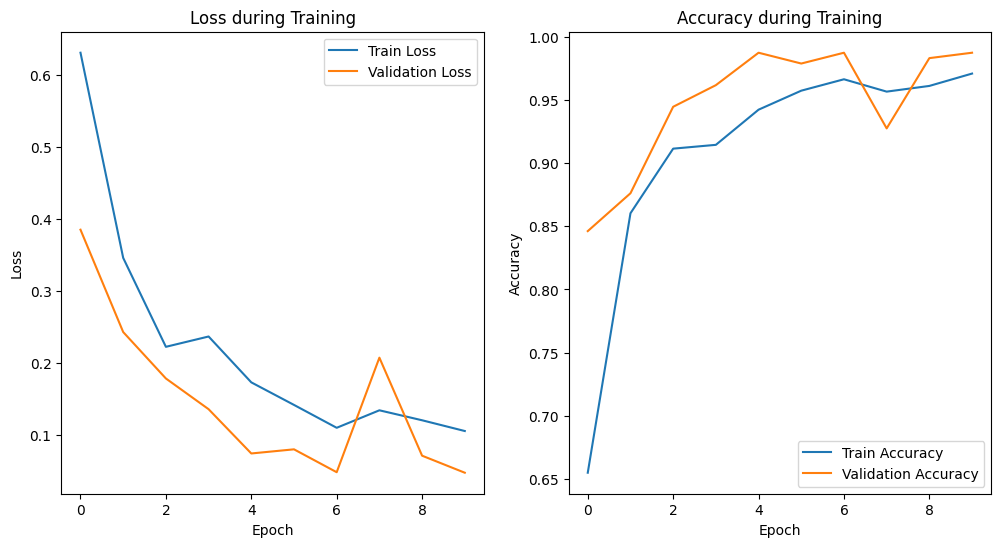

In [ ]:
# Plot Training & Validation Loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Loss during Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot Training & Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Train Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Accuracy during Training')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [ ]:
# Evaluate the model on test data
test_loss, test_accuracy = model.evaluate(test_dataset)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - accuracy: 0.9834 - loss: 0.0583
Test Loss: 0.059116166085004807
Test Accuracy: 0.9831932783126831
